In [43]:
#pip install SciencePlots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns
import pandas as pd
import scienceplots
from scipy.spatial.transform import Rotation as R

plt.rcParams.update({'pdf.fonttype': 42})

#plt.style.use(['ieee','std-colors'])
#plt.rcParams.update({
#    "font.family": "serif",   # specify font family here
#    "font.serif": ["Times New Roman"],  # specify font here
#    "font.size":11})          # specify font size here


In [2]:
exp_name = "BR_UR5e_FF"
model = "BR_20Hz_Full" #"BR_noPose_20Hz, BR_20Hz_TallRand_Uncertain"
target = "state_RL"
library = "rl_games" #"skrl"

In [ ]:

def rotMat_to_euler(rotMat):
    rotMat = rotMat.reshape(-1, 3, 2)
    last_row = np.cross(rotMat[:,:,0],rotMat[:,:,1])[:,:,np.newaxis]
    rot_full = np.concatenate([rotMat, last_row],axis=-1)
    euler = R.from_matrix(rot_full).as_euler('xyz', degrees=True)
    return euler

def rotMat_to_euler(rotMat):
    rotMat = rotMat.reshape(-1, 3, 2)
    last_row = np.cross(rotMat[:,:,0],rotMat[:,:,1])[:,:,np.newaxis]
    rot_full = np.concatenate([rotMat, last_row],axis=-1)
    euler = R.from_matrix(rot_full).as_euler('xyz', degrees=True)
    return euler

def eval_model(model="BaseModel", target="state_RL"):
    STATES_terminal = []
    MAX_eeVel = []
    MAX_eeAcc = []
    ReachingTime = []
    Max_eeOri = []
    Init_Dist = []
    Success = []
    Dropped = []
    printing=True
    for seed in range(4):
        results_dir = f"../../results/{library}/{exp_name}/{model}/{target}/seed{{}}" #DYN_IL
        n = len(os.listdir(results_dir.format(seed)))
        n_success = 0
        n_drops = 0
        for i in range(n):
            traj_ind = "{:03d}".format(i)
            success_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"success_traj.txt"), delimiter=',')
            notDropped = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"notDropped.txt"), delimiter=',')[i]
            states_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"states_traj.txt"), delimiter=',')

            if not notDropped:
                n_drops += 1

            is_success = (sum(success_traj)==len(success_traj))

            ee_pos_error  = states_traj[:, 0]
            ee_vel = states_traj[:, 3]
            ee_acc = np.gradient(ee_vel, axis=0)*20
            termErr = states_traj[-10:, :].mean(axis=0)
            
            if is_success:
                STATES_terminal.append(states_traj[-10:, :].mean(axis=0))

            is_success = is_success and termErr[0] < 0.02
            if is_success:
                n_success += 1  

                reached = ee_pos_error < 0.02
                reaching_time = np.where(reached)[0]
                ReachingTime.append(reaching_time[0] if len(reaching_time) > 0 else 96)
                #plt.plot(ee_pos_error, "k-", alpha=0.1)
            
                
                ee_vel_norm_max = np.max(ee_vel)
                MAX_eeVel.append(ee_vel_norm_max)
                ee_acc_norm_max = np.max(ee_acc)
                MAX_eeAcc.append(ee_acc_norm_max)

                Success.append(is_success)
                Dropped.append(not notDropped)
                Init_Dist.append(ee_pos_error[0])
        #print(f"Success Rate -- {model}-seed{seed} --> ({n_success/n*100:.2f}%)")
    return np.array(STATES_terminal), np.array(MAX_eeVel),  np.array(MAX_eeAcc), np.array(Init_Dist), np.array(Success), np.array(Dropped), np.array(ReachingTime)



def eval_success(model="BaseModel", target="state_RL",threshold=0.02):
    n_success = 0
    total = 0
    for seed in range(1):
        results_dir = f"../../results/{library}/{exp_name}/{model}/{target}/seed{{}}" #DYN_IL
        n = len(os.listdir(results_dir.format(seed)))        
        for i in range(n):
            traj_ind = "{:03d}".format(i)
            success_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"success_traj.txt"), delimiter=',')
            states_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"states_traj.txt"), delimiter=',')

            is_success = (sum(success_traj)==len(success_traj))
            termErr = states_traj[-10:, :].mean(axis=0)

            
            is_success = is_success and (termErr[0] < threshold)
            if is_success:
                n_success += 1              
            total += 1
                
            
    return n_success/total*100



Model:  BR_20Hz_Robust_POS


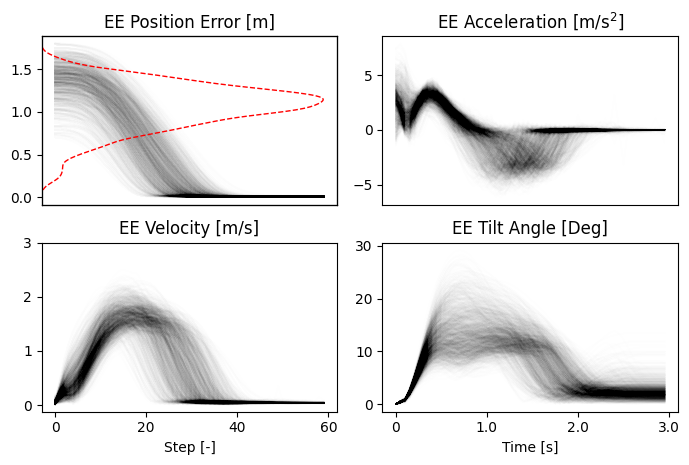

In [13]:

fig, axs = plt.subplots(2, 2, figsize=(7, 5))
print("Model: ", model)
Init_Dist = []
for envSeed in range(4):
    results_dir = f"../../results/{library}/{exp_name}/{model}/{target}/seed{{}}" #DYN_IL
    n = len(os.listdir(results_dir.format(envSeed)))
    for i in range(n):
        traj_ind = "{:03d}".format(i)
        obs_traj = np.loadtxt(os.path.join(results_dir.format(envSeed), traj_ind,"obs_traj.txt"), delimiter=',')
        success_traj = np.loadtxt(os.path.join(results_dir.format(envSeed), traj_ind,"success_traj.txt"), delimiter=',')
        states_traj = np.loadtxt(os.path.join(results_dir.format(envSeed), traj_ind,"states_traj.txt"), delimiter=',')

        ee_pos_error  = states_traj[:60, 0]
        ee_vel = states_traj[:60, 3]
        ee_acc = np.gradient(ee_vel, axis=0)*20 #freq control

        ee_rot = obs_traj[:60, 15:21]

        ee_euler = rotMat_to_euler(ee_rot)
        eeOri_norm = np.linalg.norm(ee_euler[:,:2],ord=2,axis=1)

        is_success = (sum(success_traj)==len(success_traj)) and (ee_pos_error[-10:].mean() < 0.05)
        if is_success:
            axs[0,0].plot(ee_pos_error[:], "k-", alpha=0.005)
            axs[1,0].plot(ee_vel[:], "k-", alpha=0.005)
            axs[0,1].plot(ee_acc[:], "k-", alpha=0.005)
            axs[1,1].plot(eeOri_norm[:], "k-", alpha=0.005)
            Init_Dist.append(ee_pos_error[0])

        
#axs[0].set_xticks([0, 60, 120, 180])
#axs[2].set_xlabel("Step ")
#axs[0].set_ylabel("EE Position Error [m]")
#axs[1].set_ylabel("EE Velocity [m/s]")
#axs[2].set_ylabel("EE Acceleration [m/s$^2$]")
axs[0,0].set_title("EE Position Error [m]")
axs[1,0].set_title("EE Velocity [m/s]")
axs[0,1].set_title("EE Acceleration [m/s$^2$]")
axs[1,1].set_title("EE Tilt Angle [Deg]")

axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,0].set_xticks([])
axs[0,1].set_xticks([])


axs[1,0].set_yticks([0,1.0,2.0,3.0])

plt.subplots_adjust(wspace=0.2, hspace=0.1)


axs[1,0].set_xlabel("Step [-]")
axs[1,0].set_xticks([0, 20, 40, 60])

axs[1,1].set_xlabel("Time [s]")
axs[1,1].set_xticks([0, 20, 40, 60,])
ticksLabels = [0, 1.0, 2.0, 3.0]
axs[1,1].set_xticklabels(ticksLabels)



ax2 = axs[0,0].twinx().twiny()

sns.kdeplot(y=Init_Dist,ax=ax2, linestyle="--", color="r", linewidth=1)
ax2.set_xticks([])
ax2.set_xlabel(None)
ax2.set_yticks([])

fig.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])

#fig.savefig("../../plots/BaseModel_Trajs.png", dpi=600, bbox_inches='tight')
#fig.savefig("../../plots/BaseModel_Trajs.pdf", dpi=600, bbox_inches='tight')




In [18]:
EVAL_DICT = {}
target_models = ["BR_20Hz_Full", "BR_20Hz_Full_DG", "BR_20Hz_Robust_COM", "BR_20Hz_Robust_POS"]
target_models_names = ["Optimal","Optimal-DG", "COM-Robust", "Multi-Robust"]

for model in target_models:
    STATES_terminal, MAX_eeVel, MAX_eeAcc, Init_Dist, Success, Drops, ReachingTime = eval_model(model)
    EVAL_DICT[model] = {"STATES_terminal": STATES_terminal, "MAX_eeVel": MAX_eeVel, "MAX_eeAcc": MAX_eeAcc, "Max_eeOri": Init_Dist, "Success": Success, "Drops": Drops, "ReachingTime": ReachingTime}
    STATES_terminal = np.array(STATES_terminal)
   

BR_20Hz_Full (2027,)
BR_20Hz_Full_DG (2031,)
BR_20Hz_Robust_COM (2033,)
BR_20Hz_Robust_POS (2032,)


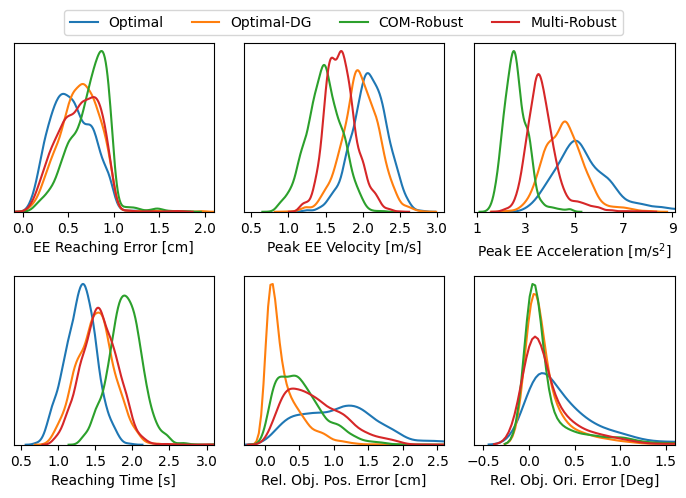

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))

for i, model in enumerate(target_models):
    STATES_terminal = EVAL_DICT[model]["STATES_terminal"]
    ee_pos_error = STATES_terminal[:, 0] * 100
    MAX_eeVel = EVAL_DICT[model]["MAX_eeVel"]
    MAX_eeAcc = EVAL_DICT[model]["MAX_eeAcc"]
    ReachingTime = EVAL_DICT[model]["ReachingTime"]* 1/ 20
    Success = EVAL_DICT[model]["Success"]
    block_pos_error = STATES_terminal[:, 1] * 100
    block_ori_error = STATES_terminal[:, 2] * 180 / np.pi
    print(model, ee_pos_error.shape)

    sns.kdeplot(ee_pos_error, label=target_models_names[i], ax=axes[0, 0])
    sns.kdeplot(MAX_eeVel, label=target_models_names[i], ax=axes[0, 1])
    sns.kdeplot(MAX_eeAcc, label=target_models_names[i], ax=axes[0, 2])
    sns.kdeplot(ReachingTime, label=target_models_names[i], ax=axes[1, 0])
    sns.kdeplot(block_pos_error, label=target_models_names[i], ax=axes[1, 1])
    sns.kdeplot(block_ori_error, label=target_models_names[i], ax=axes[1, 2])



axes[0, 0].set_xlabel("EE Reaching Error [cm]")
axes[0, 0].set_xlim([-0.1, 2.1])
axes[0, 0].set_xticks([0, 0.5, 1.0, 1.5, 2.0])

axes[1, 0].set_xlabel("Reaching Time [s]")
axes[1, 0].set_xlim([0.4, 3.1])
axes[1, 0].set_xticks([0.5, 1.0, 1.5, 2.0, 2.5,  3.0])

axes[0, 1].set_xlabel("Peak EE Velocity [m/s]")
axes[0, 1].set_xlim([0.4, 3.1])
axes[0, 1].set_xticks([0.5, 1.0, 1.5, 2.0, 2.5,  3.0])

axes[0, 2].set_xlabel("Peak EE Acceleration [m/s$^2$]")
axes[0, 2].set_xlim([0.9, 9.1])
axes[0, 2].set_xticks([1.0, 3.0, 5.0, 7.0, 9.0])

axes[1, 1].set_xlabel("Rel. Obj. Pos. Error [cm]")
axes[1, 1].set_xlim([-0.3, 2.6])
axes[1, 1].set_xticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])

axes[1, 2].set_xlabel("Rel. Obj. Ori. Error [Deg]")
axes[1, 2].set_xlim([-0.6, 1.6])
axes[1, 2].set_xticks([-0.5, 0.0, 0.5, 1.0, 1.5])


for ax in axes.flat:
    ax.set_ylabel(None)
    ax.set_yticklabels([])
    ax.set_yticks([])

#axes[0, 0].set_ylabel("Density Estimation")
#axes[1, 0].set_ylabel("Density Estimation")

# Create a shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

#fig.subplots_adjust(wspace=0.2, hspace=0.4)


plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.show()

fig.savefig("../../plots/Compare_KDE.png", dpi=600, bbox_inches='tight')
fig.savefig("../../plots/Compare_KDE.pdf", dpi=600, bbox_inches='tight')


### TensorBorad Logs

In [8]:
def get_event_data(model, tag):
    DATA  = []
    STEP = []
    for seed in range(1):
        data = []
        step = []
        log_dir = f"../../logs/rl_games/BR_UR5e_FF/{model}_seed{seed}/summaries"
        event_acc = EventAccumulator(log_dir)
        event_acc.Reload()
        events = event_acc.Scalars(tag)
        for event in events[:]:
            step.append(event.step)
            data.append(event.value)
        
        STEP.append(step)
        DATA.append(data)
    #some has a length of 998/999, some has 1000
    min_len = min([len(data) for data in DATA])
    DATA = [data[:min_len] for data in DATA]
    STEP = [step[:min_len] for step in STEP]
    return np.array(STEP), np.array(DATA)


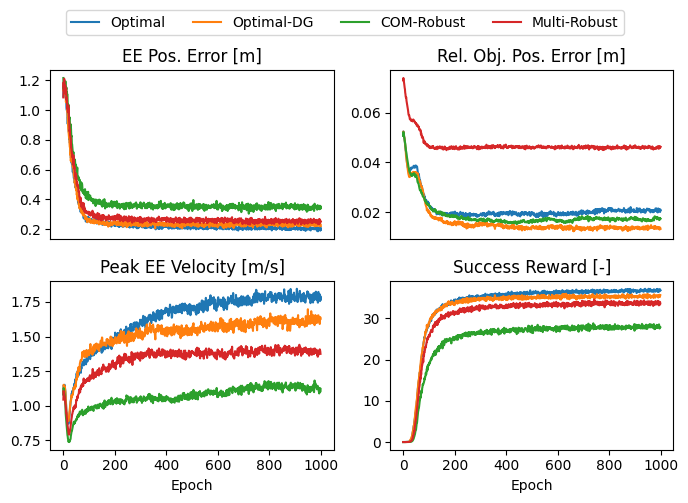

In [9]:
target_models = ["BR_20Hz_Full", "BR_20Hz_Full_DG", "BR_20Hz_Robust_COM", "BR_20Hz_Robust_POS"]
target_models_names = ["Optimal","Optimal-DG", "COM-Robust", "Multi-Robust"]

tags = ['Episode/eePos_Error', 'Episode/blockPos_Error', 'Episode/ee_maxVel', 'Episode/success_reward']
tags_names = ['EE Pos. Error [m]', 'Rel. Obj. Pos. Error [m]', 'Peak EE Velocity [m/s]', 'Success Reward [-]']
n = len(tags)
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

for k, (ax, tag) in enumerate(zip(axs.flatten(), tags)):
    for i, model in enumerate(target_models):
        STEP, DATA = get_event_data(model, tag)
        if tag == 'Episode/is_success':
            DATA = DATA * 100
        if tag == 'Episode/success_reward':
            DATA = DATA * 50

        mean_data = np.mean(DATA, axis=0)
        std_data = np.std(DATA, axis=0)
        X = np.arange(len(mean_data))
        ax.plot(X, mean_data, label=target_models_names[i])
        #ax.fill_between(X, mean_data - std_data, mean_data + std_data, alpha=0.1)

        ax.set_xlabel('Epoch')
    ax.set_title(tags_names[k])

axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,0].set_xticks([])
axs[0,1].set_xticks([])

# Create a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.01))
plt.tight_layout(rect=[0, 0, 1, 0.95])


for ax in axs[:, 1]:
    ax.yaxis.set_label_coords(-0.2, 0.5)

for ax in axs[:, 0]:
    ax.yaxis.set_label_coords(-0.2, 0.5)
plt.subplots_adjust(wspace=0.2,hspace=0.25)

plt.show()


fig.savefig("../../plots/LearningCurves.png", dpi=600, bbox_inches='tight')
fig.savefig("../../plots/LearningCurves.pdf", dpi=600, bbox_inches='tight')


### Ablations

In [10]:
exp_name = "BR_UR5e_FF"
model = "BR_20Hz_Full" #"BR_20Hz_Full_DG, BR_20Hz_Robust_COM"
library = "rl_games" #"skrl"

def rotMat_to_euler(rotMat):
    rotMat = rotMat.reshape(-1, 3, 2)
    last_row = np.cross(rotMat[:,:,0],rotMat[:,:,1])[:,:,np.newaxis]
    rot_full = np.concatenate([rotMat, last_row],axis=-1)
    euler = R.from_matrix(rot_full).as_euler('xyz', degrees=True)
    return euler

def rotMat_to_euler(rotMat):
    rotMat = rotMat.reshape(-1, 3, 2)
    last_row = np.cross(rotMat[:,:,0],rotMat[:,:,1])[:,:,np.newaxis]
    rot_full = np.concatenate([rotMat, last_row],axis=-1)
    euler = R.from_matrix(rot_full).as_euler('xyz', degrees=True)
    return euler

def eval_model2(model="BaseModel", target="state_RL", seed=0):

    MAX_eeVel = []
    MAX_eeAcc = []
    Success = []
    ReachingTime = []
    MAX_eeOri = []


    n_success = 0
    n_drops = 0
    results_dir = f"../../results/{library}/{exp_name}/{model}/{target}/seed{{}}" #DYN_IL
    n = len(os.listdir(results_dir.format(seed)))
    for i in range(n):
        traj_ind = "{:03d}".format(i)
        obs_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"obs_traj.txt"), delimiter=',')
        success_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"success_traj.txt"), delimiter=',')
        notDropped = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"notDropped.txt"), delimiter=',')[i]#[i%32]
        states_traj = np.loadtxt(os.path.join(results_dir.format(seed), traj_ind,"states_traj.txt"), delimiter=',')

        init_joint_pos = obs_traj[0,0]
        if not notDropped:
            n_drops += 1


        ee_pos_error  = states_traj[:, 0]
        ee_vel = states_traj[:, 3]

        ee_acc = np.gradient(ee_vel, axis=0)*20 #freq control


        ee_pos = obs_traj[:, 12:15]*100
        object_pos = obs_traj[:, 27:30]*100


        ee_rot = obs_traj[:, 15:21]

        ee_euler = rotMat_to_euler(ee_rot)


        eeOri_norm = np.linalg.norm(ee_euler[:,:2],ord=2,axis=1)
        max_eeOri_ind = np.argmax(eeOri_norm)
        max_eeOri = eeOri_norm[max_eeOri_ind]

        is_success = (sum(success_traj)==len(success_traj)) and (ee_pos_error[-10:].mean() < 0.05)
        Success.append(is_success)
        
        if is_success:
            n_success += 1  
            
            ee_vel_norm_max = np.max(ee_vel)
            MAX_eeVel.append(ee_vel_norm_max)
            ee_acc_norm_max = np.max(ee_acc)
            MAX_eeAcc.append(ee_acc_norm_max)

            MAX_eeOri.append(max_eeOri)
            
            reached = ee_pos_error < 0.02
            reaching_time = np.where(reached)[0]
            ReachingTime.append(reaching_time[0] if len(reaching_time) > 0 else 0)

    MAX_eeVel = np.array(MAX_eeVel)
    MAX_eeAcc = np.array(MAX_eeAcc)
    Success = np.array(Success)
    ReachingTime = np.array(ReachingTime)/20
    MAX_eeOri = np.array(MAX_eeOri)
    successRate = np.array(Success).sum()/len(Success)*100

    return MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, successRate






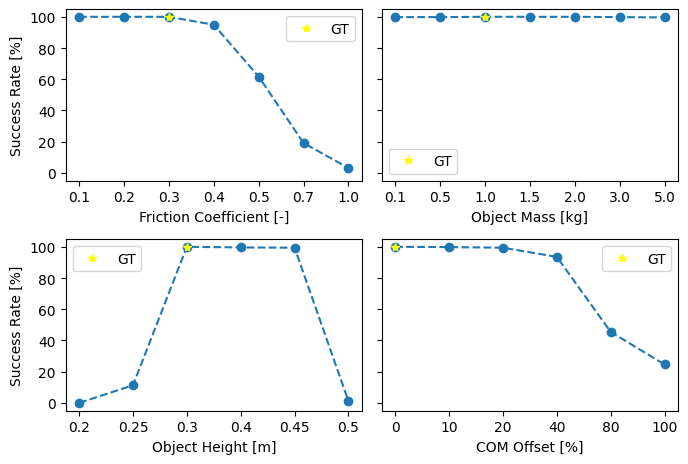

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

targets = ["state_RL_block_01Mu30H10M", "state_RL_block_02Mu30H10M", "state_RL_block_03Mu30H10M", "state_RL_block_04Mu30H10M", "state_RL_block_05Mu30H10M", "state_RL_block_07Mu30H10M", "state_RL_block_10Mu30H10M"] 
targets_names = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.7", "1.0"]

EVAL_DICT = {}
for i, target in enumerate(targets):  

    MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, successRate = eval_model2(target=target, model=model)
    EVAL_DICT[target] = {"MAX_eeVel": MAX_eeVel, "MAX_eeAcc": MAX_eeAcc, "Max_eeOri": MAX_eeOri, "ReachingTime": ReachingTime, "SR": successRate}

## Plotting Friction Coefficient
nSUC = []
for i, target in enumerate(targets):
    Success = EVAL_DICT[target]["SR"]
    nSUC.append(Success)

axs[0,0].plot(nSUC, "--", marker="o")
i = 2
axs[0,0].plot([i],[nSUC[i]], "*", color="yellow", label="GT")
axs[0,0].set_xticks(np.arange(len(targets)), targets_names)
axs[0,0].legend()

## Plotting Mass Effect
targets = ["state_RL_block_03Mu30H01M","state_RL_block_03Mu30H05M", "state_RL_block_03Mu30H10M", "state_RL_block_03Mu30H15M", "state_RL_block_03Mu30H20M", "state_RL_block_03Mu30H30M", "state_RL_block_03Mu30H50M"]
targets_names = ["0.1", "0.5", "1.0", "1.5", "2.0", "3.0", "5.0"]

EVAL_DICT = {}
for i, target in enumerate(targets):  

    MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, successRate = eval_model2(target=target, model=model)
    EVAL_DICT[target] = {"MAX_eeVel": MAX_eeVel, "MAX_eeAcc": MAX_eeAcc, "Max_eeOri": MAX_eeOri, "ReachingTime": ReachingTime, "SR": successRate}


nSUC = []
for i, target in enumerate(targets):
    Success = EVAL_DICT[target]["SR"]
    nSUC.append(Success)
axs[0,1].plot(nSUC, "--", marker="o")
i = 2
axs[0,1].plot([i],[nSUC[i]], "*", color="yellow", label="GT")
axs[0,1].set_xticks(np.arange(len(targets)), targets_names)
axs[0,1].set_xlabel('Block Mass [kg]')
axs[0,1].legend()

## Plotting Height Effect
targets = ["state_RL_block_03Mu20H10M", "state_RL_block_03Mu25H10M", "state_RL_block_03Mu30H10M", "state_RL_block_03Mu40H10M", "state_RL_block_03Mu45H10M", "state_RL_block_03Mu50H10M"]
targets_names = ["0.2", "0.25", "0.3", "0.4", "0.45", "0.5"]
EVAL_DICT = {}
for i, target in enumerate(targets):  

    MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, successRate = eval_model2(target=target, model=model)
    EVAL_DICT[target] = {"MAX_eeVel": MAX_eeVel, "MAX_eeAcc": MAX_eeAcc, "Max_eeOri": MAX_eeOri, "ReachingTime": ReachingTime, "SR": successRate}
nSUC = []
for i, target in enumerate(targets):
    Success = EVAL_DICT[target]["SR"]
    nSUC.append(Success)
axs[1,0].plot(nSUC, "--", marker="o")
i = 2
axs[1,0].plot([i],[nSUC[i]], "*", color="yellow", label="GT")
axs[1,0].set_xticks(np.arange(len(targets)), targets_names)
axs[1,0].set_xlabel('Block Height [m]')
axs[1,0].legend()


# Plotting COM
targets = ["state_RL_block_03Mu30H10M00COM", "state_RL_block_03Mu30H10M01COM", "state_RL_block_03Mu30H10M02COM", "state_RL_block_03Mu30H10M04COM", "state_RL_block_03Mu30H10M08COM", "state_RL_block_03Mu30H10M10COM"]
targets_names = ["0", "10", "20", "40","80", "100"]    
EVAL_DICT = {}
for i, target in enumerate(targets):  

    MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, successRate = eval_model2(target=target, model=model)
    EVAL_DICT[target] = {"MAX_eeVel": MAX_eeVel, "MAX_eeAcc": MAX_eeAcc, "Max_eeOri": MAX_eeOri, "ReachingTime": ReachingTime, "SR": successRate}
nSUC = []
for i, target in enumerate(targets):
    Success = EVAL_DICT[target]["SR"]
    nSUC.append(Success)
axs[1,1].plot(nSUC, "--", marker="o")
i = 0
axs[1,1].plot([i],[nSUC[i]], "*", color="yellow", label="GT")
axs[1,1].set_xticks(np.arange(len(targets)), targets_names)
axs[1,1].set_xlabel('COM Offset [m]')
axs[1,1].legend()

# same y-axis ticks for [0,0] and [0, 1] --- remove y-axis ticks for [0,1]
for ax in axs.flatten():
    ax.set_ylim([-5, 105])
    ax.set_yticks([0, 20, 40, 60, 80, 100])

axs[0,1].set_yticklabels([])
axs[1,1].set_yticklabels([])

axs[0,0].set_ylabel('Success Rate [%]')
axs[1,0].set_ylabel('Success Rate [%]')

axs[0,0].set_xlabel('Friction Coefficient [-]')
axs[0,1].set_xlabel('Object Mass [kg]')
axs[1,0].set_xlabel('Object Height [m]')
axs[1,1].set_xlabel('COM Offset [%]')

plt.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig("../../plots/Eval_Uncertainity.png", dpi=600, bbox_inches='tight')
fig.savefig("../../plots/Eval_Uncertainity.pdf", dpi=600, bbox_inches='tight')


In [71]:
targets = ["state_RL_" + i for i in ["block_Training", "cylinder", "block_lowFriction", "block_highFriction", "block_Light", "block_Heavy", "block_tall",
                                      "YCB_WoodBlock", "YCB_chips", "YCB_crackerBox", "YCB_pitcher", "YCB_powerDrill"]]
targets_names = ["Cuboids", "Cylinders", "lowFriction", "highFriction", "Light", "Heavy", "Tall", "WoodBlock", "Chips", "CrackerBox", "Pitcher", "PowerDrill"]

models = ["BR_20Hz_Full", "BR_20Hz_Full_DG", "BR_20Hz_Robust_COM"]
EVAL_DICT = {}

for model in models:
    EVAL_DICT[model]={}
    for i, target in enumerate(targets):
        try:
            MAX_eeVel, MAX_eeAcc, Success, ReachingTime, MAX_eeOri, SR = eval_model2(target=target, model=model, seed=0)
        except:
            SR = ""
        EVAL_DICT[model][targets_names[i]] = {"SR": SR}

    

In [72]:
# Create a LaTeX table from the results
def print_latex_table(models, targets_names, EVAL_DICT):
    latex_table = r"""
    \begin{table*}[ht]
    \centering
    \begin{tabular}{l|c|c|c|c|c|c|c|c|}
    \hline
    Model & Cuboids & Cylinders & lowFriction & highFriction & Light & Heavy & Tall & WoodBlock & Chips & CrackerBox & SoupCan & MustardBottle & Pitcher & PowerDrill \\ \hline

    \hline
    """

    for model in models:
        row_sr = f"{model} "
        row_nd = f"{model} "
        row_slip = f"{model} "
        AVG_SR = []
        AVG_ND = []
        AVG_Slip = []
        for i, target in enumerate(targets_names):
            SR = EVAL_DICT[model][target]["SR"]
            try:
                row_sr += f"& {SR:.2f} "
            except:
                row_sr += f"& - "


        row_sr += f"\\\\ \n"
        latex_table += row_sr
        #latex_table += row_nd
        #latex_table += row_slip
        
    latex_table += r"""
    \hline
    \end{tabular}
    \caption{Success Rates for Different Models and Targets}
    \label{tab:success_rates}
    \end{table*}
    """

    print(latex_table)

print_latex_table(models, targets_names, EVAL_DICT)



    \begin{table*}[ht]
    \centering
    \begin{tabular}{l|c|c|c|c|c|c|c|c|}
    \hline
    Model & Cuboids & Cylinders & lowFriction & highFriction & Light & Heavy & Tall & WoodBlock & Chips & CrackerBox & SoupCan & MustardBottle & Pitcher & PowerDrill \\ \hline

    \hline
    BR_20Hz_Full & 99.22 & 94.53 & 23.05 & 59.77 & 99.41 & 98.05 & 92.19 & 99.80 & 86.33 & 98.44 & 70.31 & 70.90 \\ 
BR_20Hz_Full_DG & 99.80 & 98.83 & 13.87 & 15.82 & 99.80 & 99.80 & 92.77 & 100.00 & 95.31 & 99.22 & 68.75 & 71.29 \\ 
BR_20Hz_Robust_COM & 99.22 & 100.00 & 45.90 & 51.76 & 99.22 & 99.41 & 92.19 & 100.00 & 98.83 & 100.00 & 96.88 & 94.92 \\ 

    \hline
    \end{tabular}
    \caption{Success Rates for Different Models and Targets}
    \label{tab:success_rates}
    \end{table*}
    


#### Visualizing Trajectory

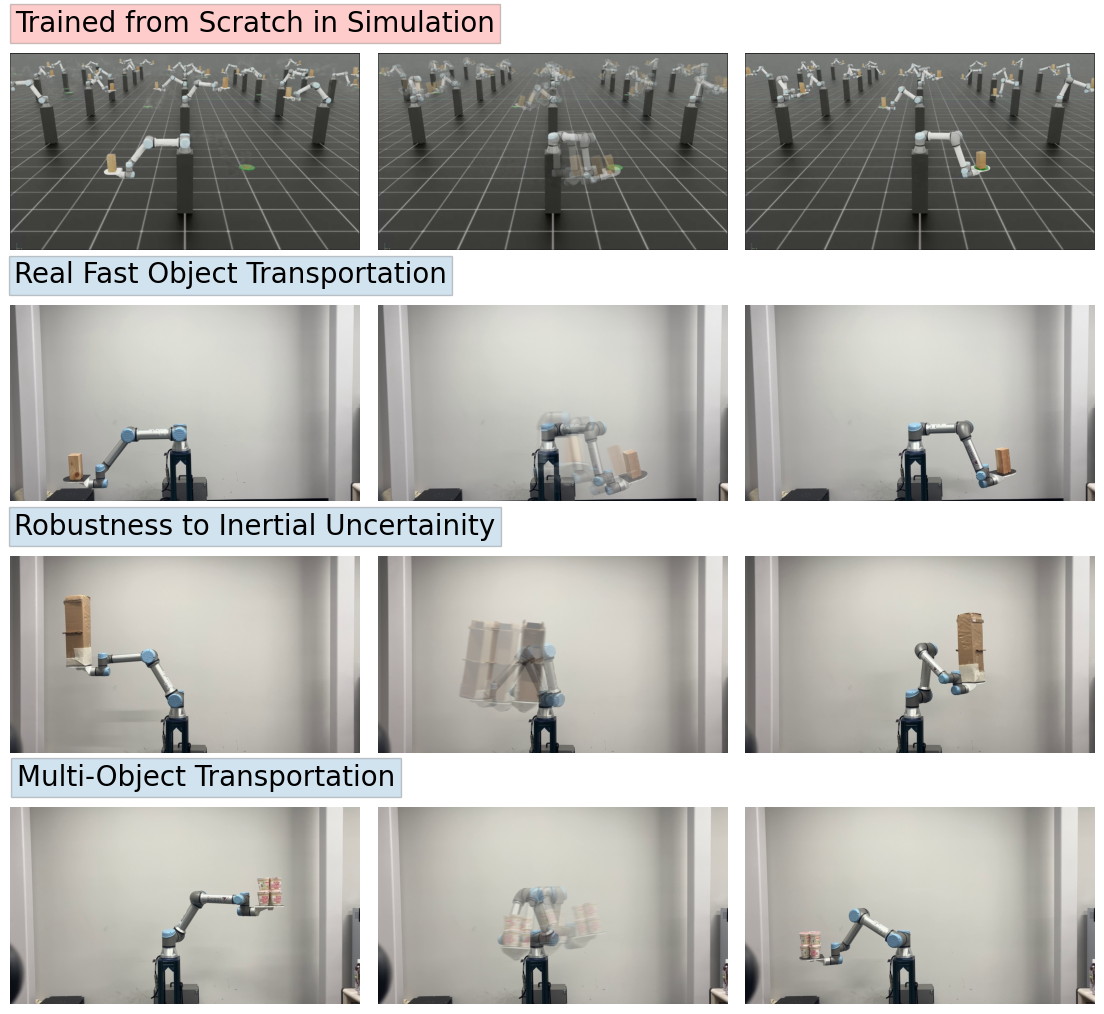

In [12]:
fig, axs = plt.subplots(4, 3, figsize=(14, 14))

figDirs = ["../../plots/WoodBlockSim/", "../../plots/WoodBlockReal/", "../../plots/TallBox/", "../../plots/MultiNoodle/"]
# list all images in the directory ordered by name
Times = [0.0, 1.0, 1.5, 3.0]
idxs = [0, 6, 15]
for i, figDir in enumerate(figDirs):
    imgs = sorted(os.listdir(figDir))
    idxs[2] = len(imgs)-1
    for j,idx in enumerate(idxs):
        imgPath = os.path.join(figDir, imgs[idx])
        img = plt.imread(imgPath)
        axs[i,j].imshow(img)
        
        alphaBlend = False if j == 0 or j == 2 else True
        if alphaBlend:
            # alpha blending 3 images
            for k in range(1, 3):
                imgPath = os.path.join(figDir, imgs[idx+k])
                img = plt.imread(imgPath)
                axs[i,j].imshow(img, alpha=0.5)
        #time = int(imgs[idx][3:5])/20
        axs[i,j].axis('off')

# remove any gaps between subplots 
plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=-0.225)

# adding text describing the images
axs[0,0].text(0.7,1.15,  "Trained from Scratch in Simulation", ha='center', va='center', fontsize=20, transform=axs[0,0].transAxes, bbox=dict(edgecolor='black', facecolor="red", alpha=0.2))
axs[1,0].text(.63, 1.15, "Real Fast Object Transportation", ha='center', va='center', fontsize=20, transform=axs[1,0].transAxes, bbox=dict(edgecolor='black', alpha=0.2))
axs[2,0].text(.7, 1.15,  "Robustness to Inertial Uncertainity", ha='center', va='center', fontsize=20, transform=axs[2,0].transAxes, bbox=dict(edgecolor='black', alpha=0.2))
axs[3,0].text(.56, 1.15, "Multi-Object Transportation", ha='center', va='center', fontsize=20, transform=axs[3,0].transAxes, bbox=dict(edgecolor='black', alpha=0.2))

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# remove any white space around the figure
fig.savefig("../../plots/teaser.png", dpi=300, bbox_inches='tight')
fig.savefig("../../plots/teaser.pdf", dpi=300, bbox_inches='tight')